In [1]:
import os, csv
import pandas as pd
import numpy as np

input_directory = 'data/personal'
input_filename = 'gnss_log_2020_12_03_19_43_12.txt'

with open(os.path.join(input_directory, input_filename)) as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        if row[0][0] == '#':
            if 'Fix' in row[0]:
                android_fixes = [row[1:]]
            elif 'Raw' in row[0]:
                measurements = [row[1:]]
        else:
            if 'Fix' in row[0]:
                android_fixes.append(row[1:])
            elif row[0] == 'Raw':
                measurements.append(row[1:])

android_fixes = pd.DataFrame(android_fixes[1:], columns = android_fixes[0])
measurements = pd.DataFrame(measurements[1:], columns = measurements[0])

We have now imported the raw GNSS measurements and location fixes from the Android log file.

Let's do a couple unit conversions.

First, we'll calculate the GPS time using the equation:

GpsTime = TimeNanos - (FullBiasNanos + BiasNanos)[ns]

In [2]:
measurements.loc[measurements['Svid'].str.len() == 1, 'Svid'] = '0' + measurements['Svid']
measurements.loc[measurements['ConstellationType'] == '1', 'Constellation'] = 'G'
measurements.loc[measurements['ConstellationType'] == '3', 'Constellation'] = 'R'
measurements['SvName'] = measurements['Constellation'] + measurements['Svid']
measurements['Cn0DbHz'] = pd.to_numeric(measurements['Cn0DbHz'])
measurements['TimeNanos'] = pd.to_numeric(measurements['TimeNanos'])
measurements['FullBiasNanos'] = pd.to_numeric(measurements['FullBiasNanos'])
measurements['ReceivedSvTimeNanos']  = pd.to_numeric(measurements['ReceivedSvTimeNanos'])
measurements['PseudorangeRateMetersPerSecond'] = pd.to_numeric(measurements['PseudorangeRateMetersPerSecond'])
measurements['ReceivedSvTimeUncertaintyNanos'] = pd.to_numeric(measurements['ReceivedSvTimeUncertaintyNanos'])
if 'BiasNanos' in measurements.columns:
    measurements['BiasNanos'] = pd.to_numeric(measurements['BiasNanos'])
else:
    measurements['BiasNanos'] = 0
if 'TimeOffsetNanos' in measurements.columns:
    measurements['TimeOffsetNanos'] = pd.to_numeric(measurements['TimeOffsetNanos'])
else:
    measurements['TimeOffsetNanos'] =0

In [3]:
from datetime import datetime, timezone, timedelta

measurements['GpsTimeNanos'] = measurements['TimeNanos'] - (measurements['FullBiasNanos'] - measurements['BiasNanos'])
gpsepoch = datetime(1980, 1, 6, 0, 0, 0)
measurements['UnixTime'] = pd.to_datetime(measurements['GpsTimeNanos'], utc=True, origin=gpsepoch)

Now let's split the data into measurement epochs. We do this by creating a new column and setting it to 1 whenever the difference between a timestamp and the previous timestamp is greater than 100 milliseconds using the DataFrame.shift() command. Then we use the cumsum method to generate numbers for the individual epochs.

In [4]:
measurements['Epoch'] = 0
measurements.loc[measurements['UnixTime'] - measurements['UnixTime'].shift() > timedelta(milliseconds=100), 'Epoch'] = 1
measurements['Epoch'] = measurements['Epoch'].cumsum()

In [5]:
WEEKSEC = 604800
LIGHTSPEED = 2.99792458e8
measurements['GpsWeekNumber'] = np.floor(1e-9 * measurements['GpsTimeNanos'] / WEEKSEC)
# This should account for rollovers since it uses a week number specific to each measurement

measurements.loc[measurements['Constellation'] == 'G', 'tRxNanos'] = measurements['TimeNanos'] - measurements['FullBiasNanos'].iloc[0] - WEEKSEC*1e9*measurements['GpsWeekNumber']
measurements['tRxSeconds'] = 1e-9*(measurements['tRxNanos'] - measurements['TimeOffsetNanos'] - measurements['BiasNanos'])
measurements['tTxSeconds'] = 1e-9*measurements['ReceivedSvTimeNanos']
measurements['prSeconds'] = measurements['tRxSeconds'] - measurements['tTxSeconds']
measurements['PrM'] = LIGHTSPEED * measurements['prSeconds']
measurements['PrSigmaM'] = LIGHTSPEED * 1e-9 * measurements['ReceivedSvTimeUncertaintyNanos']

In [6]:
from src.get_ephemeris import EphemerisManager
manager = EphemerisManager()

In [7]:
epoch = 2
timestamp = measurements.iloc[epoch]['UnixTime']
one_epoch = measurements.loc[(measurements['Constellation'] == 'G') & (measurements['Epoch'] == epoch)]
one_epoch.set_index('SvName', inplace=True)
sats = one_epoch.index.unique().tolist()
ephemeris = manager.get_ephemeris(timestamp, sats)
ephemeris.rename(columns={'M0':'M_0', 'Eccentricity':'e', 'Toe':'t_oe', 'DeltaN':'deltaN', 'Cuc':'C_uc', 'Cus':'C_us', 'Cic':'C_ic', 'Crc':'C_rc', 'Cis':'C_is', 'Crs':'C_rs', 'Io':'i_0', 'Omega0':'Omega_0'}, inplace=True)

In [8]:
timestamp = datetime(2020, 12, 4,3,43,30, 999999)
leap_seconds = 18
# this function converts a UTC timestamp into GPS time
def weekseconds(timestamp, leap_seconds):
    weekday = timestamp.weekday() + 1
    if weekday == 7:
        weekday = 0
    return 86400 * weekday + 3600 * timestamp.hour + 60 * timestamp.minute + timestamp.second + leap_seconds + 1e-6*timestamp.microsecond

In [21]:
mu = 3.986005e14
OmegaDot_e = 7.2921151467e-5
F = -4.442807633e-10
sv_position = pd.DataFrame()
sv_position['sv']= ephemeris.index
sv_position.set_index('sv', inplace=True)
sv_position['t'] = one_epoch['tTxSeconds']
sv_position['t_k'] = sv_position['t'] - ephemeris['t_oe']
A = ephemeris['sqrtA'].pow(2)
n_0 = np.sqrt(mu / A.pow(3))
n = n_0 + ephemeris['deltaN']
M_k = ephemeris['M_0'] + n * sv_position['t_k']
E_k = M_k
err = pd.Series(data=[1]*len(sv_position.index))
i = 0
while err.abs().min() > 1e-8 and i < 10:
    new_vals = M_k + ephemeris['e']*np.sin(E_k)
    err = new_vals - E_k
    E_k = new_vals
    i += 1
    
#TODO: add clock correction here
sinE_k = np.sin(E_k)
cosE_k = np.cos(E_k)
delT_r = F * ephemeris['e'].pow(ephemeris['sqrtA']) * sinE_k
sv_position['delT_sv'] = ephemeris['SVclockBias'] + delT_r


v_k = np.arctan2(np.sqrt(1-ephemeris['e'].pow(2))*sinE_k,(cosE_k - ephemeris['e']))
v_k1 = np.arctan2(np.sqrt(1-ephemeris['e'].pow(2))*sinE_k/(1-ephemeris['e']*cosE_k),(cosE_k - ephemeris['e'])/(1-ephemeris['e']*cosE_k))
Phi_k = v_k + ephemeris['omega']

sin2Phi_k = np.sin(2*Phi_k)
cos2Phi_k = np.cos(2*Phi_k)

du_k = ephemeris['C_us']*sin2Phi_k + ephemeris['C_uc']*cos2Phi_k
dr_k = ephemeris['C_rs']*sin2Phi_k + ephemeris['C_rc']*cos2Phi_k
di_k = ephemeris['C_is']*sin2Phi_k + ephemeris['C_ic']*cos2Phi_k

u_k = Phi_k + du_k

r_k = A*(1 - ephemeris['e']*np.cos(E_k)) + dr_k
r_k1 = A*((1 - ephemeris['e'].pow(2))/(1 + ephemeris['e']*np.cos(v_k))) + dr_k
i_k = ephemeris['i_0'] + di_k + ephemeris['IDOT']*sv_position['t_k']

x_k_prime = r_k*np.cos(u_k)
y_k_prime = r_k*np.sin(u_k)


Omega_k = ephemeris['Omega_0'] + (ephemeris['OmegaDot'] - OmegaDot_e)*sv_position['t_k'] - OmegaDot_e*ephemeris['t_oe']

sv_position['x_k'] = x_k_prime*np.cos(Omega_k) - y_k_prime*np.cos(i_k)*np.sin(Omega_k)
sv_position['y_k'] = x_k_prime*np.sin(Omega_k) + y_k_prime*np.cos(i_k)*np.cos(Omega_k)
sv_position['z_k'] = y_k_prime*np.sin(i_k)


We now have raw pseudorange values and satellite positions, without corrections for the earth's rotation or satellite clock bias. Let's calculate a rough user position.

In [28]:
def least_squares(xs, pr, x0, b0):
    dx = 100*np.ones(3)
    b = b0
    # set up the G matrix with the right dimensions. We will later replace the first 3 columns
    # note that b here is the clock bias in meters equivalent, so the actual clock bias is b/LIGHTSPEED
    G = np.ones((pr.size, 4))
    iterations = 0
    while np.linalg.norm(dx) > 1e-3:
        norms = np.linalg.norm(xs - x0, axis=1)
        dp = pr - norms + b - b0
        G[:, 0:3] = -(xs - x0)/norms[:, None]
        sol = np.linalg.inv(np.transpose(G)@G) @ np.transpose(G) @ dp
        dx = sol[0:3]
        db = sol[3]
        norm_dp = np.linalg.norm(dp)
        x0 = x0 + dx
        b0 = b0 + db
        iterations += 1
    print(str(iterations) + ' iterations')
    return x0, b0, norm_dp


In [29]:
import navpy
#initial guesses of receiver clock bias and position
b0 = 0
x0 = np.array([0, 0, 0])
xs = sv_position[['x_k', 'y_k', 'z_k']].to_numpy()

pr = one_epoch['PrM'] + LIGHTSPEED * sv_position['delT_sv']
pr = pr.to_numpy()
x, b , norm_dp = least_squares(xs, pr, x0, b0)
print(b/LIGHTSPEED)
print(norm_dp)
print(navpy.ecef2lla(x))

5 iterations
-3.4057964977634127e-08
64.4523216639963
(47.68680180952868, -122.36232221048529, 101.07999258767813)


Text(0, 0.5, 'Cn0DbHz')

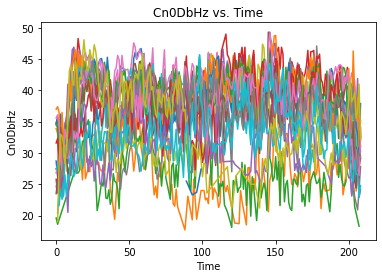

In [24]:
import matplotlib.pyplot as plt

measurements['ElapsedTimeSeconds'] = 1e-9*(measurements['GpsTimeNanos'] - measurements['GpsTimeNanos'].iloc[0])

# create a color palette
for satellite in measurements['SvName'].unique():
    one_sat = measurements.loc[measurements['SvName'] == satellite]
    plt.plot(one_sat['ElapsedTimeSeconds'], one_sat['Cn0DbHz'])

# Add titles
plt.title('Cn0DbHz vs. Time')
plt.xlabel("Time")
plt.ylabel('Cn0DbHz')


